# IVOA interop meeting, Trieste, 21 October 2016

### Query SDSS Data Release 13, save thumbnails to SciDrive

This notebook shows you how to use SciServer Compute to communicate with the other components of SciServer. You will learn how to:

1. Connect this notebook with your SciServer login portal account (using a Keystone token)
1. Import special-purpose Python libraries to work with SciServer
1. Use CasJobs to query databases such as the Sloan Digital Sky Survey's Data Release 13 (DR13) database.
1. Write Python code to plot SDSS data in a variety of ways.
1. Store subsets of SDSS data in your private database (MyDB) for later analysis.
1. Use Python to process and analyze your selected data.
1. Store the results of your analysis on a local scratch disk (as an HD5 file) for later reuse.
1. Retrieve thumbnail images for your selected objects from the SDSS Data Archive Server, directly from this notebook using Docker.
1. Save the thumbnails to your SciDrive, where you can easily share them with your colleagues.

# 1. Sign in to SciServer

All SciServer tools (CasJobs, SciDrive, iPython Notebooks, etc.) use the same single-sign-on system, so you only need to remember one password. The code block below reads the token and stores it in a local variable, then prints its value along with your login name.

Note: since your token may expire, you should sometimes refresh the token as you work. If you get a permissions error, this is the likely cause. You can do refresh your token by re-running the block of code below.

In [50]:
# This code block defines your token and makes it available as a system variable 
##    for the length of your current session.
# This will usually be the first code block in any script you write.
import SciServer.LoginPortal as Login            # import user management library
token=Login.getToken()                           # get token value, then print
print("Your current token is"+token)
user = Login.getKeystoneUserWithToken(token)     # get username from token value, then print
print("Your username is: "+user.userName)

Your current token isdfe524b092114cc7bb51cb6af2b1650d
Your username is: raddick


# 2. Import SciServer libraries 
The SciServer team has written a number of libraries, generally prefixed by <tt>SciServer</tt>, that assist in various functions. As with all Python libraries, they must be actively imported before being used. The next code block imports those, together with some standard Python libraries helpful for scientific analysis. The code block also applies some settings you may find helpful.

In [51]:
# Step 2a: Import Python libraries to work with SciServer components
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive

# Step 2b: Import other libraries
import numpy as np                  # standard Python lib for math operations
import pandas                       # data management package
import matplotlib.pyplot as plt     # graphing package
import skimage.io                   # image processing library
import urllib                       # parse URLs
import json                         # Work with Javascript object notation (.json) files

# Step 2c: Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)   # ensure dataframe columns have correct width
import warnings
warnings.filterwarnings('ignore')               # do not show Python warnings
print("Packages imported, options set!")
# Also, some other options: the SDSS data release and links to some resources.
dataRelease = 13            # The SDSS data release you want to search
docsURL = 'http://www.sciserver.org/docs'        
schemaURL = 'http://skyserver.sdss.org/DR'+str(dataRelease)+'/help/browser/browser.aspx'
pandasURL = 'http://pandas.pydata.org/'
pyplotURL = 'http://matplotlib.org/api/pyplot_api.html'
scidriveURL = 'http://www.scidrive.org/'
casJobsURL = 'http://skyserver.sdss.org/casjobs/'

Packages imported, options set!


# 3. Query an astronomy database (SDSS DR13)

The next code block searches the SDSS Data Release 13 database via the CasJobs REST API. The query completes quickly, so it uses CasJobs quick mode. CasJobs also has an asynchronous mode, which will submit job to a queue and will store the results in a table in your MyDB. If your results are very large, it will store the results in MyScratchDB instead.

Run the code block below to query SDSS DR13. Try changing some of the query parameters in step 3a to see the effect on the results returned in step 3d. Documentation on the SciServer Python libraries can be found at our documentation site the link printed by the code block below:

In [52]:
print(docsURL)

http://www.sciserver.org/docs


In [53]:
# Step 3a: Find objects in the Sloan Digital Sky Survey's Data Release 13.
# Queries the Sloan Digital Sky Serveys' Data Release 13.
# For the database schema and documentation see http://skyserver.sdss.org
#
# This query finds "a 4x4 grid of nice-looking galaxies": 
##   galaxies in the SDSS database that have a spectrum 
##   and have a size (petror90_r) larger than 10 arcsec.
##   It also gets their magnitudes so we can later make a CMD.
# 
# First, store the query in an object called "query". Note the triple 
##  quotes used for parsing.
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
# Step 3b: Send the query to CasJobs.
#   WHAT PARAMETERS DOES CasJobs.executeQuery take?
# This example uses DR13 as context - the code makes a connection 
#   to the DR13 database, then runs the query in quick mode.
queryResponse = CasJobs.executeQuery(query, "dr13",token=token)

# Step 3c: store results in a format for easy analysis, then show results.
#
# Results have been returned as a CSV table called "queryResponse".
# Now parse the results into a DataFrame object using PANDAS.
#    pandas.read_csv documentation: 
#      http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
# Also, note that we use the SDSS table's primary key (galaxies.objId) as the 
##     index column in the dataframe.
gals = pandas.read_csv(queryResponse, index_col='objId')  # Note that we use the table's primary key as the index
# Step 3d: show the table of results
gals

ra       dec  petror90_r
objId                                                
1237645941824356443  40.285690  -0.714957  14.72862  
1237645943978393694  55.123625   0.872487  18.85110  
1237645943979114622  56.847420   0.875488  15.66479  
1237645943979311221  57.248385   0.925979  14.60275  
1237646588246688297  80.135126   1.186679  11.14294  
1237648672921485632  243.708876 -0.915653  15.01578  
1237648672922337955  245.700633 -0.844301  10.51866  
1237648672922468973  246.015172 -0.902869  10.80825  
1237648673459077169  245.367353 -0.457074  11.18379  
1237648673459667002  246.695626 -0.510111  10.27149  
1237648673459667234  246.782081 -0.492432  11.98310  
1237648673460585255  248.894520 -0.452329  11.48170  
1237648673971437623  189.522249 -0.027031  21.94494  
1237648673992671592  237.945144 -0.105170  13.36310  
1237648673994965546  243.236782 -0.096251  26.27760  
1237648673995686549  244.875590 -0.038526  12.17980

#### Run the code block below to print links to some helpful resources.

In [54]:
print("SciServer Python modules documentation: "+docsURL)
print("")
print("Schema of SDSS Data Release "+str(dataRelease)+": "+schemaURL)
print("")
print("Pandas documentation: "+pandasURL)

SciServer Python modules documentation: http://www.sciserver.org/docs

Schema of SDSS Data Release 13: http://skyserver.sdss.org/DR13/help/browser/browser.aspx

Pandas documentation: http://pandas.pydata.org/


# 4. Make a simple plot

Now that we have run the query and stored the results, we can start analyzing the results.

Let's use PyPlot to a simple plots of galaxy positions (ra vs. dec). You can make a simple preview plot with just the simple code below.

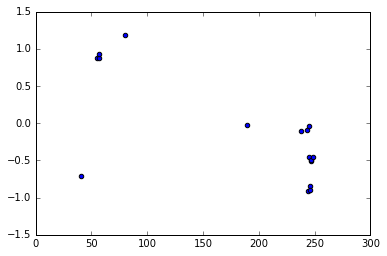

In [55]:
# preview plot:
plt.scatter(gals['ra'],gals['dec'])
plt.show()

Or you can make a plot with axis labels and titles with the code below:

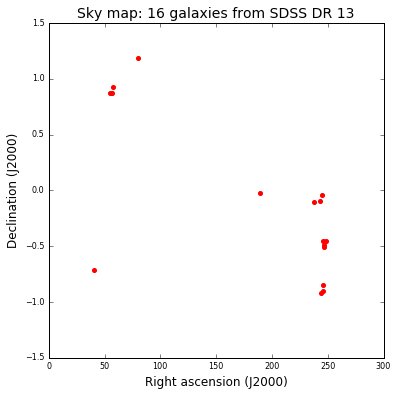

In [56]:
nGalaxies = gals['ra'].count()

skymap = plt.figure(figsize=(6,6))

ax1 = skymap.add_subplot(1,1,1) # one row, one column, first plot

ax1.scatter(gals['ra'],gals['dec'], s=16,color="red", marker="o")
#ax4.axis([0,10,0,100])
ax1.tick_params(axis='both', which='major', labelsize=8)
# Add a title.
#title_string = 'Sky Map of'+'{:,.0f}'.format(nGalaxies)+'galaxies'
title_string = 'Sky map: '+str(nGalaxies)+' galaxies from SDSS DR '+str(dataRelease)
ax1.set_title(title_string,fontsize=14)
# Add some axis labels.
ax1.set_xlabel("Right ascension (J2000)",fontsize=12)
ax1.set_ylabel("Declination (J2000)",fontsize=12)
skymap.show()   # show the plot

# 5. Store results in your container for later use

The next Code block saves the data table "gals" into your container as an HD5 file and as a CSV file.

To see these files, go back to your iPython notebook dashboard (the page from which you opened this notebook). Make sure you are in the <b>persistent</b> folder. You should see your files there. Click on the file names to preview.

In [57]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()
print('HD5 file saved')

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')
print('CSV file saved')

HD5 file saved
CSV file saved


# 6. Retrieve thumbnail cutouts of galaxies and show them on screen

SciServer's Image Cutout web services will produce a color image cutout of certain dimensions around a specified position, displayed as a JPG thumbnail. For a single image, you can construct the URL of the service using your query results, then use the skimage package to call the URL. To get all thumbnails in your query result, you can iterate using a loop.

The code block below gives an example of how to retrieve JPG thumbnails of galaxies using SciServer's Image Cutout web service. The code takes some time to run, but should complete within one minute.

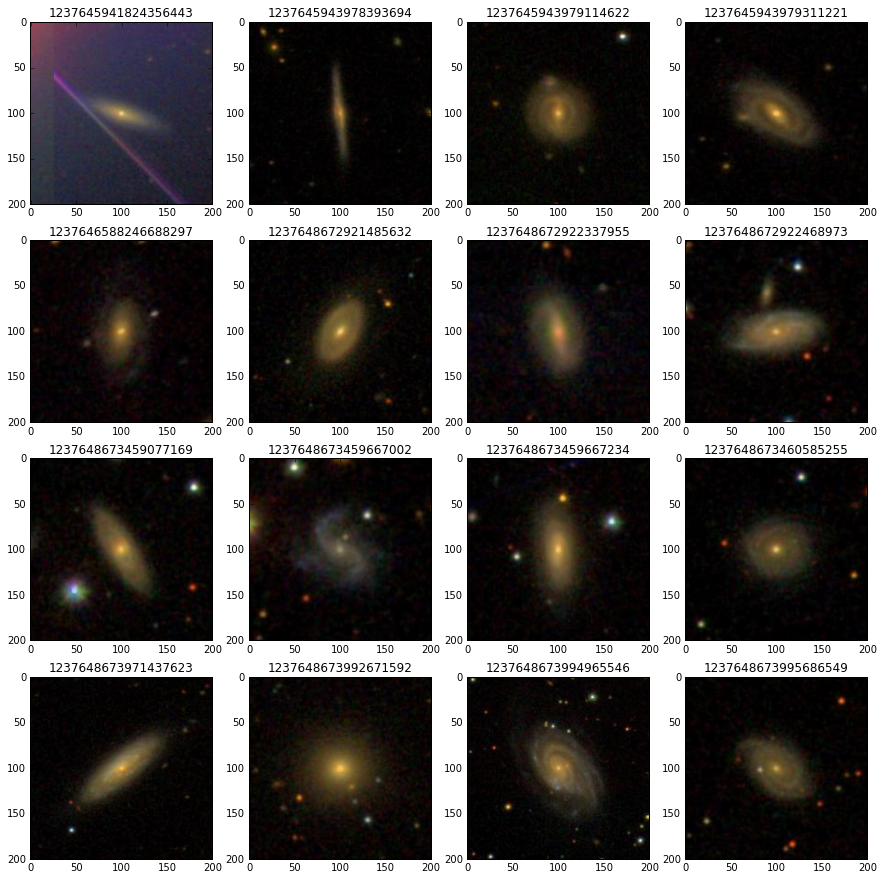

In [58]:
width=200                    # width and height of each thumbnail in pixels
height=200
pixelsize=0.396              # pixel scale of thumnbails in arcsec per pixel. This 0.396 value is true scale.
plt.figure(figsize=(15, 15)) # create a 16x16 grid template with pyplot
subPlotNum = 1

for index,gal in gals.iterrows():    # iterate through each row of the dataframe and construct the needed URL
    scale=2*gal['petror90_r']/pixelsize/width   # uses the Petrosian radius of each galaxy to set scale
    url="http://skyservice.pha.jhu.edu/DR"+str(dataRelease)+"/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
#    print(url)
    img=skimage.io.imread(url)
    plt.subplot(4,4,subPlotNum)
    subPlotNum += 1
    plt.imshow(img)
# show the object identifier (objId) above the image.
    plt.title(index)

# 7. Write thumbnails to SciDrive

SciDrive is a Dropbox-like interface to scientific data. It works with all the other components of SciServer, including Compute, so you can create and manipulate files there through this notebook interface.

In [59]:
# Step 7a: generate a public URL to be used by SciDrive
def scidrivePublicURL(path):
    req = urllib.request.Request(url=SciServer.Config.SciDriveHost+'/vospace-2.0/1/media/sandbox/'+path,method='GET') 
    req.add_header('X-Auth-Token', token) 
    req.add_header('Content-Type','application/xml') 
    res=urllib.request.urlopen(req)
    jsonResponse = json.loads(res.read().decode())
    return jsonResponse['url']

# Step 7b: create a container in your SciDrive to hold the thumbnail images
container = 'ivoademo'
# IMPORTANT: Only run next if the container does not yet exist. If you have already created 
#   the container, comment out the next line.
SciServer.SciDrive.createContainer(container,token=token)

# Step 7c: Write thumbnails to SciDrive. You will see a confirmation message below
#   for each thumbnail.
width=200
height=200
pixelsize=0.396

puburls=[]
for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    req = urllib.request.Request(url=url,method='GET')
    res = urllib.request.urlopen(req)
    data=res.read()
    scidrivename_name = container+"/new_"+str(index)+".jpg"
# Here the file gets uploaded to the container
    SciServer.SciDrive.upload(scidrivename_name, data,token=token)
    puburls.append(scidrivePublicURL(scidrivename_name))
gals['pubURL']=puburls

# print the URL of the first thumbnail as a final confirmation message.
print("URL of first thumbnail: "+puburls[0])

{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4034,"modified":"Thu, 20 Oct 2016 07:32:10 -0400","path":"/ivoademo/new_1237645941824356443.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.6 KB","rev":1,"thumb_exists":false,"bytes":3658,"modified":"Thu, 20 Oct 2016 07:32:11 -0400","path":"/ivoademo/new_1237645943978393694.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"4.2 KB","rev":1,"thumb_exists":false,"bytes":4265,"modified":"Thu, 20 Oct 2016 07:32:12 -0400","path":"/ivoademo/new_1237645943979114622.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.7 KB","rev":1,"thumb_exists":false,"bytes":3762,"modified":"Thu, 20 Oct 2016 07:32:12 -0400","path":"/ivoademo/new_1237645943979311221.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4036,"modified":"Thu, 20 Oct 2

Now check your SciDrive to make sure that the thumbnail JPGs are stored in the correct container. Run the code block below to show the link to SciDrive. Log in there and look for the container whose name you specified above.

In [60]:
print("SciDrive URL: "+scidriveURL)

SciDrive URL: http://www.scidrive.org/


# 8. Store all results in a table in your MyDB

So far, you have found data about some galaxies in SDSS Data Release 13. In addition to the data that DR13 provides, you have also used SciServer libraries to find thumbnail images for each galaxy. Now, you will store all this information in a new table in your CasJobs "MyDB" personal database space.

Remember that all the data you queried from DR13 is now stored in a PANDAS dataframe called "gals". You'll be starting from that data frame to save your results in your MyDB. Before saving the dataframe as a table in your MyDB, you will add another column giving the link to each galaxy's thumbnail in SciDrive.

It the operation has succeeded, you will see a message that says:

<code>uploadCVSDataFrameToTable POST response:  200 OK</code>

In [64]:
# Step 8a: First, add another column to the data frame to give a link to the thumbnails you saved into SciDrive.
gals['pubURL']=puburls
# print out the data frame to verify that the new column has been added.
gals

# Step 8b: create a new table in your MyDB to hold your results.
# You can create a new table using the SQL "CREATE TABLE" statement. Note that you must specify the 
#    columns correctly before you try to write data into the table.
#    If you want to save the data into an existing table instead, skip this step - just make sure that the 
#    schema of the existing table exactly matches the structure of the data frame.
newTableCmd = """CREATE TABLE GalaxyThumbsIVOAdemo(objId bigint, ra real, dec real, petror90_r real, pubURL varchar(128))"""
response = SciServer.CasJobs.executeQuery(newTableCmd,token=token)
print('New table created')

# Step 8c: upload data from the Data Frame directly into the MyDB table you just created.
response=SciServer.CasJobs.uploadPandasDataFrameToTable(gals,"GalaxyThumbsIVOAdemo",token=token)

# another option: upload to CasJobs by first converting to CSV
#response=SciServer.CasJobs.uploadCVSDataToTable(gals.to_csv().strip().encode("utf8"),"GalaxyThumbsIVOA",token=token)


New table created
Uploading  2382 bytes...
uploadCVSDataFrameToTable POST response:  200 OK


Congratulations! You have searched through data from SDSS, retrieved thumbnails of each galaxy, and saved the results to your MyDB! The code block below generates the URL of your MyDB so you can see the result.

Feel free to modify this notebook to suit your needs, and contact us at <a href="mailto:sciserver-helpdesk@lists.johnshopkins.edu">sciserver-helpdesk@lists.johnshopkins.edu</a> with any questions!

In [65]:
print('Your MyDB location: '+casJobsURL+'MyDB.aspx')

Your MyDB location: http://skyserver.sdss.org/casjobs/MyDB.aspx
